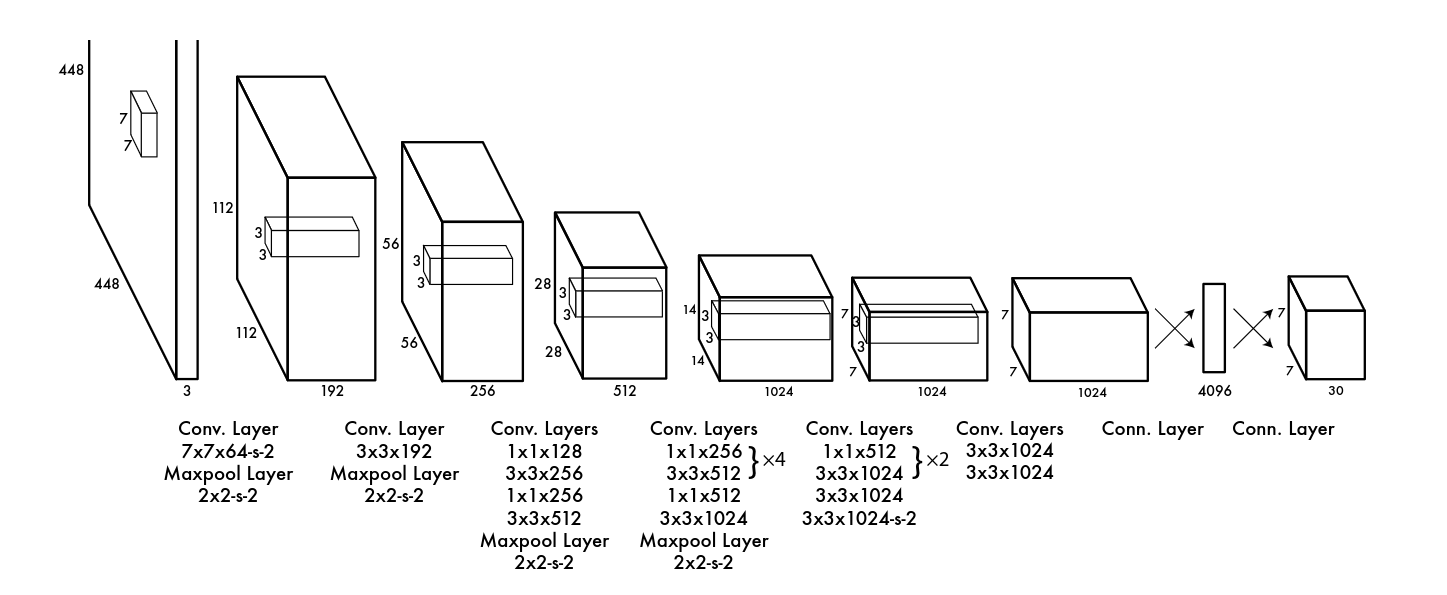

### Armando el dataset

In [97]:
from utils.datasets import YOLODataset
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import torch

In [26]:
img_path = "data/headliners/images"
label_path = "data/headliners/labels"

S = 7
B = 2
num_classes = 9
input_size = 448


transform = transforms.Compose([
                                transforms.Resize((input_size, input_size)),
                                transforms.ToTensor()
                            ])

In [27]:
dataset = YOLODataset(img_path, label_path, S, B, num_classes, transforms = transform)

## Visualizing the data

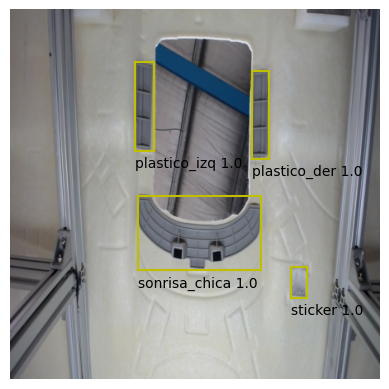

In [123]:
img, label = dataset[101]
draw_img_and_bbox_from_true_labels(img, label)

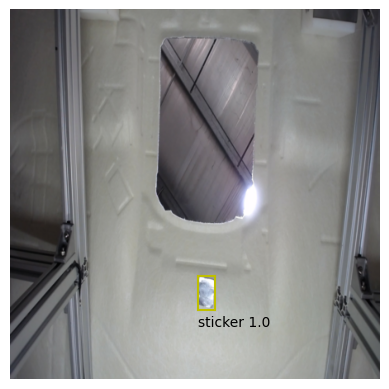

In [138]:
import draw_bbox
index = 106
img, label = dataset[index]
draw_bbox.draw_img_and_bbox_from_true_labels(img, label)

tensor(0.)


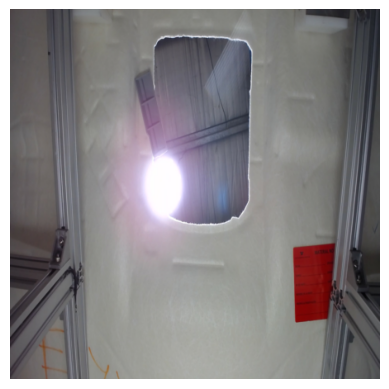

In [140]:
# El indice 105 no tiene ningun objeto? El label es solo ceros. Pero parece tener un plastico ahi.
index = 105
img, label = dataset[index]
draw_bbox.draw_img_and_bbox_from_true_labels(img, label)
print(label.sum())

In [163]:
def draw_several_imgs_and_bboxes_from_true_labels():
    """
    Takes img and labels from the dataset class and draws a PIL image with the bounding boxes for the labeled data.
    """
    fig, axis = plt.subplots(2,5, figsize = (15,5))
    counter = 0
    for k in range(2):
        for l in range(5):
            
            img, labels = dataset[counter]
            ax = axis[k, l]
            ax.imshow(torch_to_pil(img))
            ax.axis("off")

            #ahora las bounding box
            img_size = 448
            grid_labels = labels[3,3,:]

            for i in range(7):
                for j in range(7):
                    grid_labels = labels[i,j,:]
                    draw_grid_bbox(grid_labels, ax)
            counter = counter+1

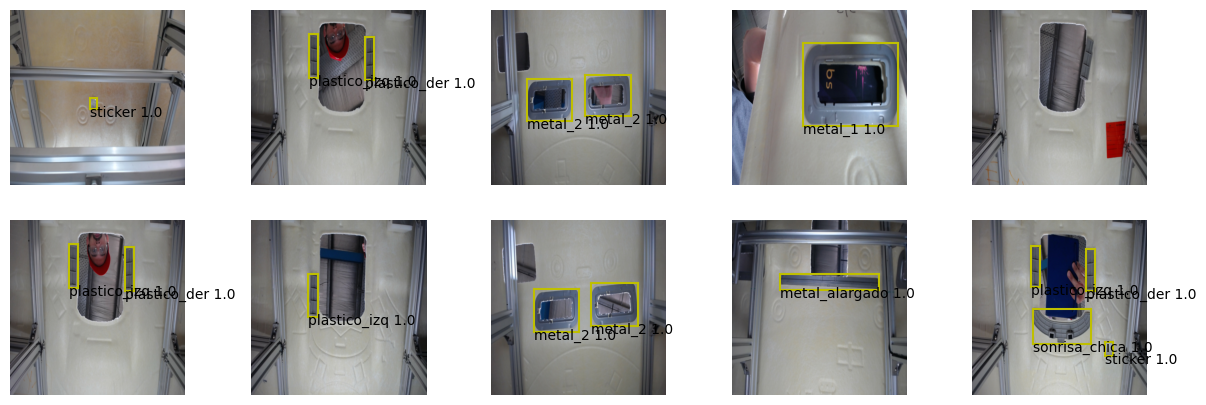

In [164]:
draw_several_imgs_and_bboxes_from_true_labels()

## Creating data loader

In [1]:
import torch
torch.cuda.memory_allocated()

0

Model training

In [5]:
import os
import time

import matplotlib.pyplot as plt
import torch
from torch.optim import SGD
from torchvision import utils

from utils import create_dataloader, YOLOv1Loss, parse_cfg, build_model
from train import train, validate, test

In [8]:
def main(cfg="cfg/yolov1.yaml", dataset_cfg="cfg/dataset.yaml", weights="", output="output", epochs=100, lr=0.002, batch_size=32, save_freq=10):
    
    cfg = parse_cfg(cfg)
    dataset_cfg = parse_cfg(dataset_cfg)

    img_path, label_path = dataset_cfg['images'], dataset_cfg['labels']
    S, B, num_classes, input_size = cfg['S'], cfg['B'], cfg['num_classes'], cfg['input_size']
    
    # create output file folder
    start = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
    output_path = os.path.join(output, start)
    os.makedirs(output_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # build model
    torch.manual_seed(1)
    model = build_model(weights, S, B, num_classes).to(device)

    # get data loader
    train_loader, val_loader, test_loader = create_dataloader(img_path, label_path, 0.8, 0.1, 0.1, batch_size,
                                                              input_size, S, B, num_classes)

    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    # optimizer = Adam(model.parameters(), lr=lr)

    train_loss_lst, val_loss_lst = [], []

    # train epoch
    for epoch in range(epochs):
        train_loss_lst = train(model, train_loader, optimizer, epoch, device, S, B, train_loss_lst, output_path)
        val_loss_lst = validate(model, val_loader, device, S, B, val_loss_lst)

        # save model weight every save_freq epoch
        if epoch % save_freq == 0 and epoch >= epochs / 2:
            torch.save(model.state_dict(), os.path.join(output_path, 'epoch' + str(epoch) + '.pth'))

    test(model, test_loader, device, S, B)

    # save model
    torch.save(model.state_dict(), os.path.join(output_path, 'last.pth'))

    # plot loss, save params change
    fig = plt.figure()
    plt.plot(range(epochs), train_loss_lst, 'g', label='train loss')
    plt.plot(range(epochs), val_loss_lst, 'k', label='val loss')
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('acc-loss')
    plt.legend(loc="upper right")
    plt.savefig(os.path.join(output_path, 'loss_curve.jpg'))
    plt.show()
    plt.close(fig)

In [9]:
main()

Config: {'S': 7, 'B': 2, 'num_classes': 9, 'input_size': 448}
Config: {'images': 'data/headliners/images/', 'labels': 'data/headliners/labels/', 'class_names': ['fondo', 'metal_1', 'metal_2', 'metal_alargado', 'plastico_der', 'plastico_izq', 'sonrisa_chica', 'sonrisa_grande', 'sticker']}


: 

: 